In [1]:
# !pip install tensorflow-io

In [2]:
# imports
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

2024-02-08 02:46:39.572492: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-08 02:46:39.619950: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-08 02:46:39.620575: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-08 02:46:40.479869: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
DATASET_PATH = 'data/'
data_dir = pathlib.Path(DATASET_PATH)

In [4]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.3,
    seed=0,
    output_sequence_length=32000*6,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 613 files belonging to 2 classes.
Using 491 files for training.
Using 122 files for validation.

label names: ['no' 'yes']


In [5]:
train_ds.element_spec

(TensorSpec(shape=(None, 192000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [6]:
val_ds.element_spec

(TensorSpec(shape=(None, 192000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [7]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [8]:
test_ds.element_spec

(TensorSpec(shape=(None, 192000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [9]:
val_ds.element_spec

(TensorSpec(shape=(None, 192000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [10]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)
test_ds = test_ds.map(squeeze, tf.data.AUTOTUNE)

In [11]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 192000)
(64,)


In [12]:
!pip install pydub

In [13]:
# # # error because I just overwrite the .mp3 to wav, didn't change format

# from pydub import AudioSegment
# import os
# def mp3_to_wav(mp3_file, wav_file):
#     # Load MP3 file
#     audio = AudioSegment.from_mp3(mp3_file)

#     wav_audio = audio.set_frame_rate(32000).set_channels(1).set_sample_width(2)
#     # Export as WAV
#     audio.export(wav_file, format="wav")

# # Replace 'input.mp3' and 'output.wav' with your input and output file paths
# for file in os.listdir('data/no'):
#     mp3_to_wav(f'data/no/{file}', f'data/no/{file}')


# # reencode the yes files
# from pydub import AudioSegment

# def reencode_wav(input_wav, output_wav, new_format="wav", channels=2, sample_width=2, frame_rate=44100):
#     # Load WAV file
#     audio = AudioSegment.from_wav(input_wav)

#     # Set audio parameters for the new encoding
#     reencoded_audio = audio.set_channels(channels).set_sample_width(sample_width).set_frame_rate(frame_rate)

#     # Export as the new format
#     reencoded_audio.export(output_wav, format=new_format)

# # Replace 'input.wav' and 'output_reencoded.wav' with your input and output file paths
# root = 'data/yes'
# for file in os.listdir(root):
#     reencode_wav(f'{root}/{file}', f'{root}/{file}', new_format="wav", channels=1, sample_width=2, frame_rate=32000)

In [14]:
# convert to spectrogram

In [15]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [16]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=32000))

Label: yes
Waveform shape: (192000,)
Spectrogram shape: (1499, 129, 1)
Audio playback


Label: no
Waveform shape: (192000,)
Spectrogram shape: (1499, 129, 1)
Audio playback


Label: yes
Waveform shape: (192000,)
Spectrogram shape: (1499, 129, 1)
Audio playback


In [17]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

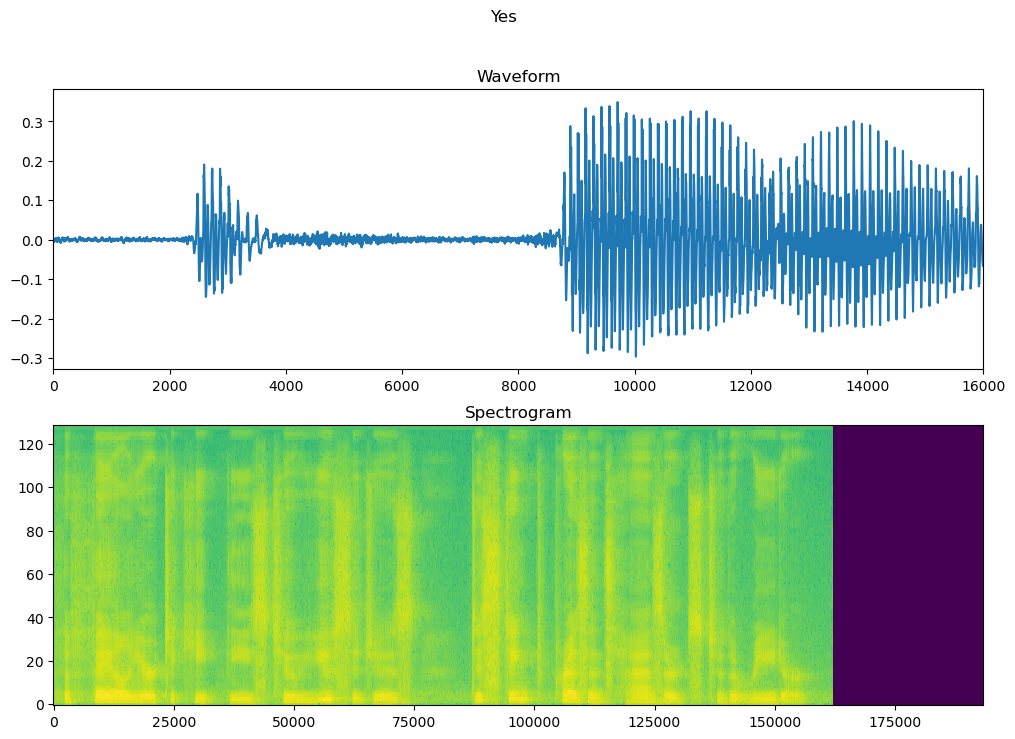

In [18]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [19]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [20]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [21]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

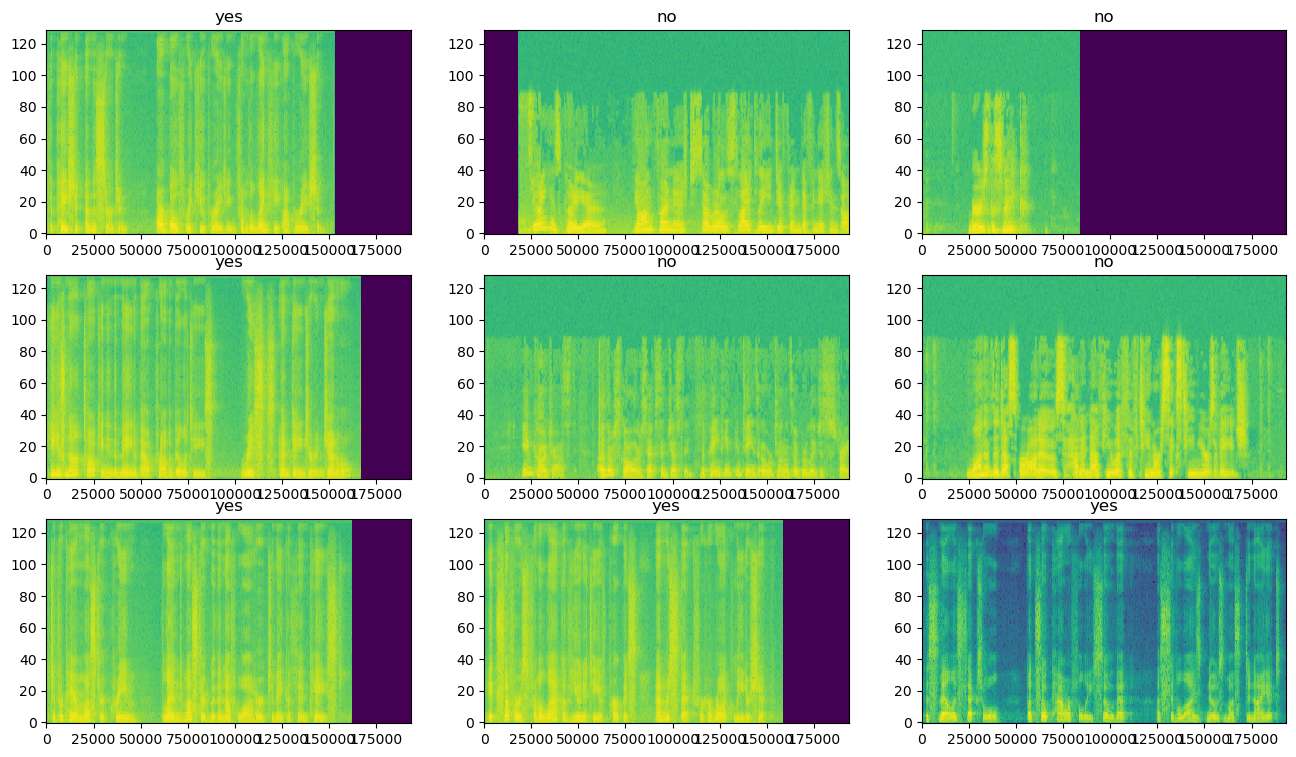

In [22]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [23]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [24]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (1499, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)          

In [25]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
8/8 [==============================] - 2s 196ms/step - loss: 0.6351 - accuracy: 0.6497 - val_loss: 0.4837 - val_accuracy: 0.8966
Epoch 2/10
8/8 [==============================] - 0s 55ms/step - loss: 0.4013 - accuracy: 0.8635 - val_loss: 0.2916 - val_accuracy: 0.8966
Epoch 3/10
8/8 [==============================] - 0s 50ms/step - loss: 0.3044 - accuracy: 0.8717 - val_loss: 0.2055 - val_accuracy: 0.9138
Epoch 4/10
8/8 [==============================] - 0s 53ms/step - loss: 0.1952 - accuracy: 0.9348 - val_loss: 0.2099 - val_accuracy: 0.8966
Epoch 5/10
8/8 [==============================] - 0s 47ms/step - loss: 0.1485 - accuracy: 0.9511 - val_loss: 0.1565 - val_accuracy: 0.9138
Epoch 6/10
8/8 [==============================] - 0s 52ms/step - loss: 0.0995 - accuracy: 0.9654 - val_loss: 0.1674 - val_accuracy: 0.9138
Epoch 7/10
8/8 [==============================] - 0s 59ms/step - loss: 0.0859 - accuracy: 0.9756 - val_loss: 0.1265 - val_accuracy: 0.9483
Epoch 8/10
8/8 [==========

In [ ]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [ ]:
model.evaluate(test_spectrogram_ds, return_dict=True)

In [ ]:
model.evaluate(val_spectrogram_ds, return_dict=True)

In [ ]:
y_pred = model.predict(test_spectrogram_ds)

In [ ]:
y_pred = tf.argmax(y_pred, axis=1)

In [ ]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()